# Camera Calibration

In [1]:
import cv2
import numpy as np

In [2]:
board_dim = (8,6)
size = 24
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [3]:
object_3d = np.zeros((board_dim[0] * board_dim[1], 3), np.float32)
index = 0
for i in range(board_dim[0]):
    for j in range(board_dim[1]):
        object_3d[index][0] = i * size
        object_3d[index][1] = j * size
        index += 1
#print
object_points_3d = []  # world points
image_points_2d = []  # image plane points

In [4]:
import glob
image_files = ['1.jpg','2.jpg','3.jpg','4.jpg','5.jpg','6.jpg','7.jpg','8.jpg','9.jpg','10.jpg','11.jpg']
for image in image_files:
    #print(image)
    
    img = cv2.imread(image)
    image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

     
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(image, board_dim, None)
    if ret == True:
        object_points_3d.append(object_3d)
        corners2 = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)
        image_points_2d.append(corners2)

        img = cv2.drawChessboardCorners(image, board_dim, corners2, ret)

In [5]:
ret, mtx, dist_coeff, R_vecs, T_vecs = cv2.calibrateCamera(object_points_3d, image_points_2d, gray.shape[::-1], None, None)
print("calibrated\n")
print("ret:\n",ret)
print("K_matrix:\n",mtx)
print("dist_coeff:\n",dist_coeff)
print("R_vec:\n",R_vecs)
print("T_vec:\n",T_vecs)

calibrated

ret:
 224.42576473785843
K_matrix:
 [[5.52248460e+03 0.00000000e+00 4.52246531e+02]
 [0.00000000e+00 1.70119301e+03 4.71870253e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_coeff:
 [[ 1.24385256e+02 -9.15192038e+03 -3.81484395e-02 -9.06721914e-01
   1.94595556e+05]]
R_vec:
 (array([[-1.09718752],
       [-1.13898711],
       [ 1.0092353 ]]), array([[-1.22861368],
       [-1.13598967],
       [ 1.22009847]]), array([[1.34848034],
       [1.24493258],
       [1.20196238]]), array([[ 2.48648482],
       [ 2.35277449],
       [-2.46063016]]), array([[-1.08669613],
       [-1.13449365],
       [ 0.95291443]]), array([[-1.25486127],
       [-1.13737825],
       [ 1.15817053]]), array([[ 2.65052088],
       [ 2.57322762],
       [-2.30655856]]), array([[-1.27770602],
       [-1.09965603],
       [ 1.11055416]]), array([[1.28651337],
       [1.24643985],
       [1.16699541]]))
T_vec:
 (array([[ 53.19006774],
       [-81.68876061],
       [778.38861523]]), array([[ 89.8

# F-matix and Relative Pose

In [6]:
import matplotlib.pyplot as plt

# Part (a) Estimating the fundamental matrix

In [7]:
# Load the images
img_left = cv2.imread("left.jpg", cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread("right.jpg", cv2.IMREAD_GRAYSCALE)

# Using sift detector to detect features
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_left, None)
kp2, des2 = sift.detectAndCompute(img_right, None)

# Using Flann descriptor for feature matiching
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Applying Lowe's ratio test
good_matches = []
pts1 = []
pts2 = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Fundamental matrix
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

print("Fundamental Matrix : ", F)

Fundamental Matrix :  [[ 8.08082370e-08  2.15593476e-07 -3.55470430e-04]
 [-5.51433046e-07  3.88280986e-07  2.71911784e-03]
 [-2.99284935e-04 -2.80460817e-03  1.00000000e+00]]


# Part (b) Epipolar lines

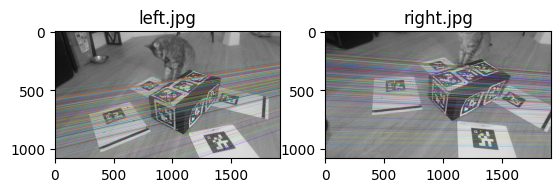

In [8]:
# Select inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Epipolar lines
def draw_epilines(img1, img2, lines, pts1, pts2):
    r, c = img1.shape
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1_color = cv2.line(img1_color, (x0, y0), (x1, y1), color, 1)
        img1_color = cv2.circle(img1_color, tuple(pt1), 5, color, -1)
        img2_color = cv2.circle(img2_color, tuple(pt2), 5, color, -1)
    return img1_color, img2_color

# Epipolar lines in the left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = draw_epilines(img_left, img_right, lines1, pts1, pts2)

# Epipolar lines in the right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = draw_epilines(img_right, img_left, lines2, pts2, pts1)

# Display the images with epipolar lines
plt.subplot(121), plt.imshow(img5),plt.title("left.jpg")
plt.subplot(122), plt.imshow(img3),plt.title("right.jpg")
plt.show()

# Part (c) Calculating the essential matrix

In [9]:
# K matrix
K = np.array([[5.52248460e+03, 0, 4.52246531e+02],
              [0, 1.70119301e+03, 4.71870253e+02],
              [0,  0,  1]]) 
E = K.T @ F @ K

# Step 5: Decompose Essential Matrix
U, S, Vt = np.linalg.svd(E)
W = np.array([[0, -1, 0],
              [1,  0, 0],
              [0,  0, 1]])

# Possible rotations and translations
R1 = U @ W @ Vt
R2 = U @ W.T @ Vt
t = U[:, 2]

# Ensure proper rotation matrix
if np.linalg.det(R1) < 0:
    R1 = -R1
if np.linalg.det(R2) < 0:
    R2 = -R2

print("Rotation Matrix R1:\n", R1)
print("Rotation Matrix R2:\n", R2)
print("Translation Vector t:\n", t)

Rotation Matrix R1:
 [[ 0.7615839  -0.53863878  0.36035848]
 [ 0.54529174  0.83309106  0.09282351]
 [-0.35020977  0.12580761  0.92818401]]
Rotation Matrix R2:
 [[ 0.281311    0.05057601  0.95828294]
 [-0.35167421 -0.92370183  0.15198745]
 [ 0.89285462 -0.37975914 -0.24206121]]
Translation Vector t:
 [0.87530712 0.1625042  0.45544465]
